# Track Machine Learning experiments and models

##### This notebook demonstrates an anomaly detection process on a sales dataset using Spark, Pandas, and Isolation Forest. The steps include:
###### 1. Initializing a Spark session and enabling Arrow optimization for efficient data transfer between Spark and Pandas.
###### 2. Loading the entire sales dataset from the lakehouse into a Spark DataFrame.
###### 3. Converting the Spark DataFrame to a Pandas DataFrame for further processing.
###### 4. Cleaning the 'Sales' column by removing non-numeric characters and converting 'Sales' and 'Profit' columns to numeric types.
###### 5. Dropping rows with NaN values in the 'Sales' and 'Profit' columns.
###### 6. Normalizing the 'Sales' and 'Profit' data using StandardScaler.
###### 7. Initializing and fitting an Isolation Forest model to detect anomalies in the normalized data.
###### 8. Predicting anomalies and classifying data points as normal or anomalous.
###### 9. Visualizing the anomalies using a scatter plot with improved readability and aesthetics.


StatementMeta(, a4df96f3-88b7-479a-a9b9-04ba35473c90, 14, Finished, Available, Finished)

Number of entries in the table: 5901


Number of anomalies detected: 73


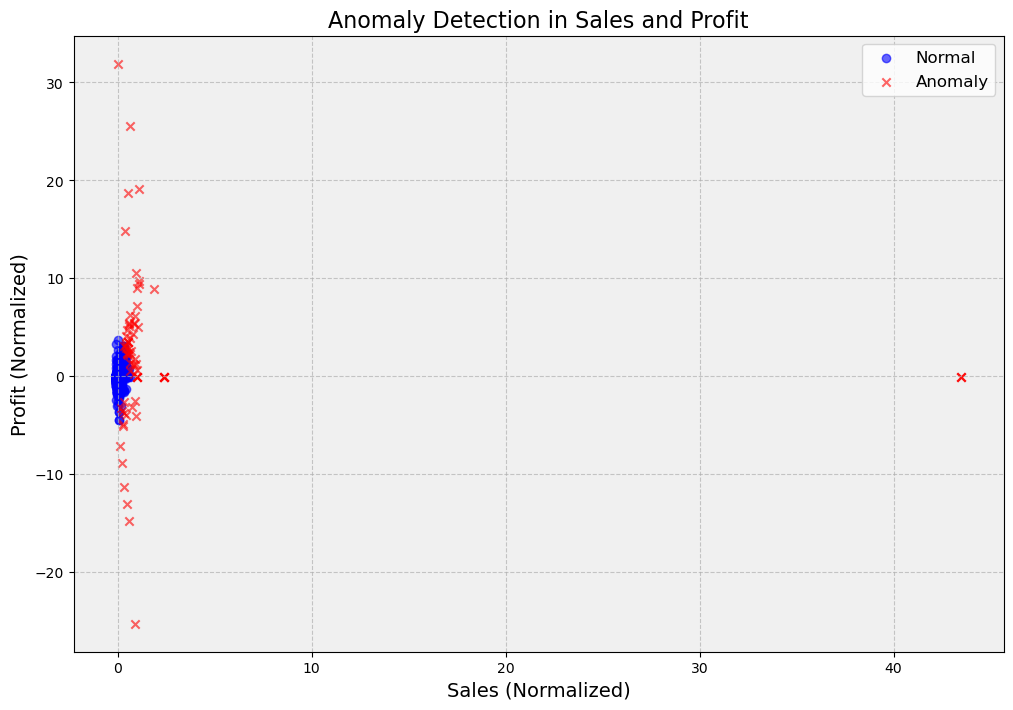

In [12]:
import pandas as pd
import re
from pyspark.sql import SparkSession
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Initialize Spark session
spark = SparkSession.builder.appName("LakehouseTraining").getOrCreate()

# Enable Arrow optimization
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

# Load the entire table into a Spark DataFrame
df = spark.sql("SELECT * FROM lakehouseTraining.`superstore sales dataset`")
entry_count = df.count()
print("Number of entries in the table:", entry_count)

# Convert Spark DataFrame to Pandas DataFrame
pandas_df = df.toPandas()

# Clean the 'Sales' column by removing non-numeric characters
pandas_df['Sales'] = pandas_df['Sales'].apply(lambda x: re.sub(r'[^0-9.]', '', str(x)))

# Convert 'Sales' and 'Profit' columns to numeric
pandas_df['Sales'] = pd.to_numeric(pandas_df['Sales'], errors='coerce')
pandas_df['Profit'] = pd.to_numeric(pandas_df['Profit'], errors='coerce')

# Drop rows with NaN values
pandas_df.dropna(subset=['Sales', 'Profit'], inplace=True)

# Normalize the data
scaler = StandardScaler()
pandas_df[['Sales', 'Profit']] = scaler.fit_transform(pandas_df[['Sales', 'Profit']])

# Initialize the Isolation Forest model
iso_forest = IsolationForest(contamination=0.0125, random_state=42)

# Fit the model
iso_forest.fit(pandas_df[['Sales', 'Profit']].values)

# Predict anomalies using the same feature names
pandas_df['anomaly'] = iso_forest.predict(pandas_df[['Sales', 'Profit']].values)

# Define normal and anomaly data points
normals = pandas_df[pandas_df['anomaly'] == 1]
anomalies = pandas_df[pandas_df['anomaly'] == -1]

print("Number of anomalies detected:", len(anomalies))
#print(anomalies)

# Visualize the anomalies with improvements
plt.figure(figsize=(12, 8))
plt.scatter(normals['Sales'], normals['Profit'], c='blue', label='Normal', alpha=0.6, marker='o')
plt.scatter(anomalies['Sales'], anomalies['Profit'], c='red', label='Anomaly', alpha=0.6, marker='x')
plt.xlabel('Sales (Normalized)', fontsize=14)
plt.ylabel('Profit (Normalized)', fontsize=14)
plt.title('Anomaly Detection in Sales and Profit', fontsize=16)
plt.legend(loc='upper right', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.gca().set_facecolor('#f0f0f0')
plt.show()

StatementMeta(, a4df96f3-88b7-479a-a9b9-04ba35473c90, 15, Finished, Available, Finished)

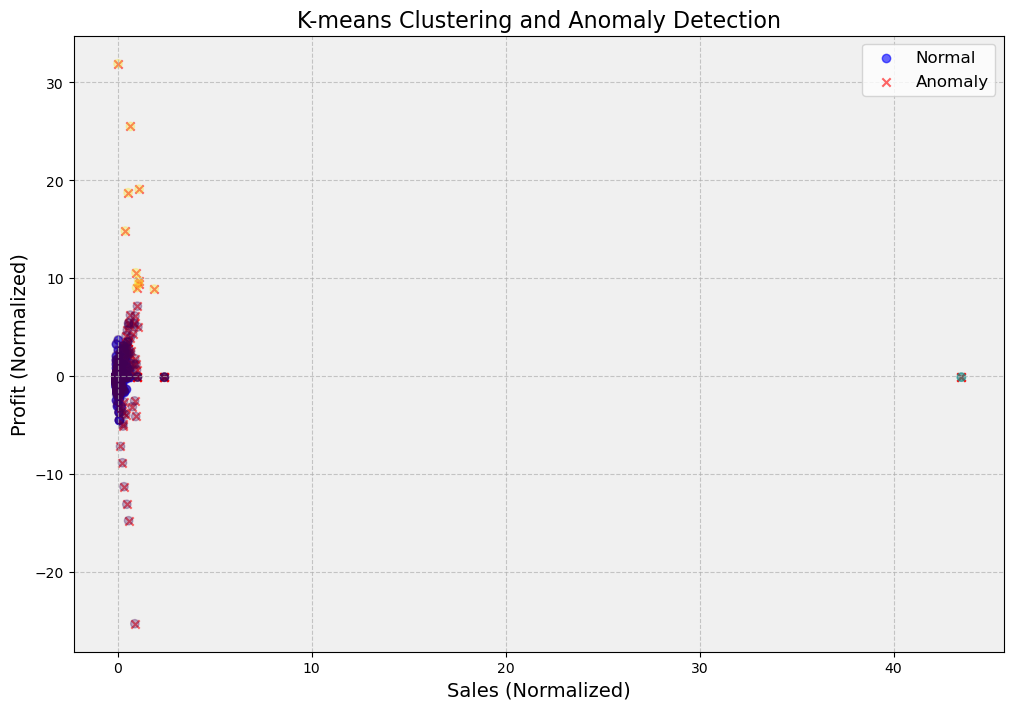

In [13]:
from sklearn.cluster import KMeans

# Apply K-means clustering with explicit n_init value
kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
pandas_df['cluster'] = kmeans.fit_predict(pandas_df[['Sales', 'Profit']])

# Visualize the clusters and anomalies
plt.figure(figsize=(12, 8))
plt.scatter(pandas_df[pandas_df['anomaly'] == 1]['Sales'], pandas_df[pandas_df['anomaly'] == 1]['Profit'], c='blue', label='Normal', alpha=0.6, marker='o')
plt.scatter(pandas_df[pandas_df['anomaly'] == -1]['Sales'], pandas_df[pandas_df['anomaly'] == -1]['Profit'], c='red', label='Anomaly', alpha=0.6, marker='x')
plt.scatter(pandas_df['Sales'], pandas_df['Profit'], c=pandas_df['cluster'], cmap='viridis', alpha=0.3)
plt.xlabel('Sales (Normalized)', fontsize=14)
plt.ylabel('Profit (Normalized)', fontsize=14)
plt.title('K-means Clustering and Anomaly Detection', fontsize=16)
plt.legend(loc='upper right', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.gca().set_facecolor('#f0f0f0')
plt.show()

StatementMeta(, a4df96f3-88b7-479a-a9b9-04ba35473c90, 16, Finished, Available, Finished)

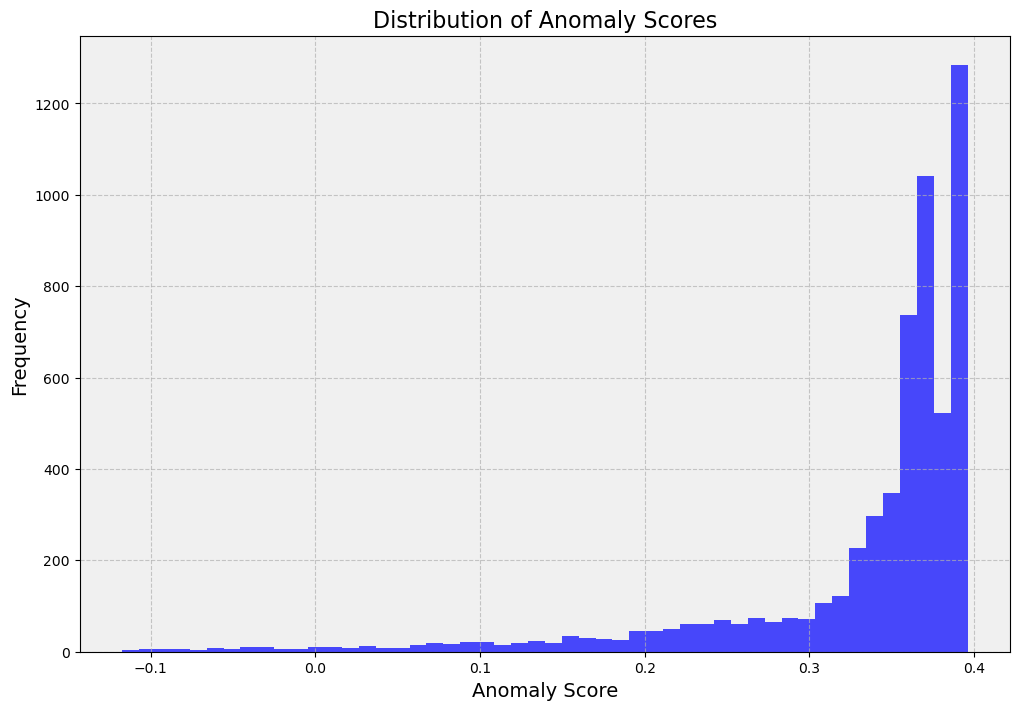

         Sales     Profit  anomaly_score
4138  1.111039  19.104113      -0.117458
2768  0.890550 -25.281435      -0.113495
1343  1.886869   8.907592      -0.108989
551   1.085468   9.769281      -0.107306
2592  1.097608   9.434729      -0.106745
3080  0.944691  10.562531      -0.105066
1336  0.977175   9.040993      -0.104507
3302  1.022233   7.155438      -0.100606
287   0.662254  25.510276      -0.100050
1426  0.932298  -4.115726      -0.098939


In [14]:
# Extract anomaly scores
pandas_df['anomaly_score'] = iso_forest.decision_function(pandas_df[['Sales', 'Profit']].values)

# Visualize the distribution of anomaly scores
plt.figure(figsize=(12, 8))
plt.hist(pandas_df['anomaly_score'], bins=50, color='blue', alpha=0.7)
plt.xlabel('Anomaly Score', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Anomaly Scores', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.gca().set_facecolor('#f0f0f0')
plt.show()

# Print the top 10 anomalies with the lowest scores
top_anomalies = pandas_df.nsmallest(10, 'anomaly_score')
print(top_anomalies[['Sales', 'Profit', 'anomaly_score']])